In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import sympy

import def_all_CRNs as CRNs
from dae_finder import (
        AlgModelFinder,
        PolyFeatureMatrix,
        add_noise_to_df,
        get_refined_lib,
        sequentialThLin,
        smooth_data,
)

### Discovery of Algebraic Relationships

In [2]:
num_points = 1000
noise_perc = 0

In [3]:
# 1) Make data
clean_data = CRNs.make_CRN2(5, num_points)
clean_df = pd.DataFrame(clean_data, columns=['t', 'A', 'B', 'C', 'E1', 'AE1', 'E2', 'AE2'])

data_matrix_df_list = [clean_df.iloc[i:i+num_points].reset_index(drop=True) for i in range(0, len(clean_df), num_points)]

tSolve = list(data_matrix_df_list[0]['t'])
num_time_points = len(tSolve)

# 2) Noise data
for ind, data_matrix_ in enumerate(data_matrix_df_list):
        t_exact = data_matrix_["t"]
        noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=8) # Use trial as RNG seed
        noisy_data_df["t"] = t_exact
        data_matrix_df_list[ind] = noisy_data_df

data_matrix_df_appended = pd.concat(data_matrix_df_list, ignore_index=True)

data_matrix_features = data_matrix_df_list[0].columns

# 3) Smooth noisy data
data_matrix_smooth_df_list = [
    smooth_data(data_matrix[:num_points],
                domain_var="t",
                smooth_method ="SG",
                noise_perc=0.1,
                derr_order=1,
                polyorder=2,
                window_smooth=None)[10:-10] #trimming zero derivatives near end points
    for data_matrix in data_matrix_df_list]

if len(data_matrix_smooth_df_list) == 1:
        data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0].reset_index(drop=True)
else:
        data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)

data_matrix_df_new= data_matrix_df_smooth_appended[['A', 'B', 'C', 'E1', 'AE1', 'E2', 'AE2']]


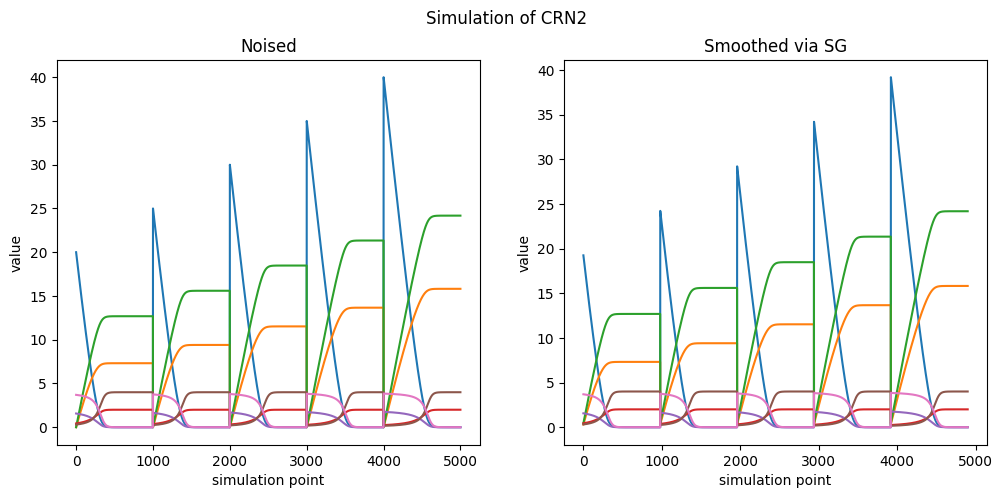

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

axes[0].plot(data_matrix_df_appended.drop('t', axis=1))
axes[0].set_title("Noised")

axes[1].plot(data_matrix_df_new)
axes[1].set_title("Smoothed via SG")

axes[0].set_xlabel("simulation point")
axes[1].set_xlabel("simulation point")

axes[0].set_ylabel("value")
axes[1].set_ylabel("value")

# Shared title
fig.suptitle("Simulation of CRN2")

# Show the plot
plt.show()

In [5]:
# 4) Make lib
poly_degree = 2

poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)

print("Degree of library: {}".format(poly_degree))
print("# terms in the library: {}".format(candidate_lib_full.shape[1]))
print("Full candidate library has the following features: {}".format(list(candidate_lib_full.columns)))

Degree of library: 2
# terms in the library: 35
Full candidate library has the following features: ['A', 'B', 'C', 'E1', 'AE1', 'E2', 'AE2', 'A^2', 'A B', 'A C', 'A E1', 'A AE1', 'A E2', 'A AE2', 'B^2', 'B C', 'B E1', 'B AE1', 'B E2', 'B AE2', 'C^2', 'C E1', 'C AE1', 'C E2', 'C AE2', 'E1^2', 'E1 AE1', 'E1 E2', 'E1 AE2', 'AE1^2', 'AE1 E2', 'AE1 AE2', 'E2^2', 'E2 AE2', 'AE2^2']


In [6]:
# 5) Make feats
feat_list = ['A', 'B', 'C', 'E1', 'AE1', 'E2', 'AE2']
feat_list_str = ", ".join(feat_list)
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

In [7]:
# 6) Find first rel (mass conservation)
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(data_matrix_df_new, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 0 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


['E1', 'AE1']

In [8]:
# 6) Find first rel (mass conservation)
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(data_matrix_df_new.drop('E1', axis=1), scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 0 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 0 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


['E2', 'AE2']

In [9]:
# 7) Remove first, second rels (mass conservation of enz)
features_to_remove, refined_candid_lib = get_refined_lib({E1, E2}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['E1^2', 'E2 AE2', 'E2', 'E1', 'A E2', 'E2^2', 'AE1 E2', 'E1 AE2', 'B E2', 'A E1', 'E1 AE1', 'B E1', 'C E1', 'C E2', 'E1 E2']
# terms in the library: 20
Candidate library has the following features: ['A', 'B', 'C', 'AE1', 'AE2', 'A^2', 'A B', 'A C', 'A AE1', 'A AE2', 'B^2', 'B C', 'B AE1', 'B AE2', 'C^2', 'C AE1', 'C AE2', 'AE1^2', 'AE1 AE2', 'AE2^2']


In [10]:
# 8) Search for QSSA
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations


['AE1', 'AE2', 'AE1^2', 'AE1 AE2', 'AE2^2']

In [11]:
# 9) Remove second rel (mass conservation of other enz)
features_to_remove, refined_candid_lib = get_refined_lib({E1, E2, AE1*AE2}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['E1^2', 'E2 AE2', 'AE1 AE2', 'E2', 'E1', 'A E2', 'AE1 E2', 'E1 AE2', 'B E2', 'C E2', 'A E1', 'E1 AE1', 'B E1', 'C E1', 'E2^2', 'E1 E2']
# terms in the library: 19
Candidate library has the following features: ['A', 'B', 'C', 'AE1', 'AE2', 'A^2', 'A B', 'A C', 'A AE1', 'A AE2', 'B^2', 'B C', 'B AE1', 'B AE2', 'C^2', 'C AE1', 'C AE2', 'AE1^2', 'AE2^2']


In [12]:
# 10) Continue to remove; for plotting cond num + SVD
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations


['B C', 'B^2', 'C^2']

In [13]:
features_to_remove, refined_candid_lib = get_refined_lib({E1, E2, AE1*AE2, B*C}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['E1^2', 'E2 AE2', 'AE1 AE2', 'B C', 'E2', 'E1', 'A E2', 'AE1 E2', 'E1 AE2', 'B E2', 'C E2', 'A E1', 'E1 AE1', 'B E1', 'C E1', 'E2^2', 'E1 E2']
# terms in the library: 18
Candidate library has the following features: ['A', 'B', 'C', 'AE1', 'AE2', 'A^2', 'A B', 'A C', 'A AE1', 'A AE2', 'B^2', 'B AE1', 'B AE2', 'C^2', 'C AE1', 'C AE2', 'AE1^2', 'AE2^2']


In [14]:
# 10 cont.) Continue to remove; for plotting cond num + SVD
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations


['AE1', 'AE2', 'AE1^2', 'AE2^2']

In [15]:
features_to_remove, refined_candid_lib = get_refined_lib({E1, E2, AE1*AE2, B*C, AE1**2}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['E1^2', 'AE1 AE2', 'AE1^2', 'A E2', 'AE1 E2', 'E1 AE1', 'B E1', 'C E1', 'E1 E2', 'E2 AE2', 'B C', 'E2', 'E1 AE2', 'B E2', 'C E2', 'A E1', 'E1', 'E2^2']
# terms in the library: 17
Candidate library has the following features: ['A', 'B', 'C', 'AE1', 'AE2', 'A^2', 'A B', 'A C', 'A AE1', 'A AE2', 'B^2', 'B AE1', 'B AE2', 'C^2', 'C AE1', 'C AE2', 'AE2^2']


In [16]:
# 10 cont.) Continue to remove; for plotting cond num + SVD
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations


['A', 'AE1', 'A AE1', 'A AE2']

In [18]:
features_to_remove, refined_candid_lib = get_refined_lib({E1, E2, AE1*AE2, B*C, AE1**2, A*AE2}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['E1^2', 'AE1 AE2', 'AE1^2', 'A E2', 'AE1 E2', 'A AE2', 'E1 AE1', 'B E1', 'C E1', 'E1 E2', 'E2 AE2', 'B C', 'E2', 'E1 AE2', 'B E2', 'C E2', 'A E1', 'E1', 'E2^2']
# terms in the library: 16
Candidate library has the following features: ['A', 'B', 'C', 'AE1', 'AE2', 'A^2', 'A B', 'A C', 'A AE1', 'B^2', 'B AE1', 'B AE2', 'C^2', 'C AE1', 'C AE2', 'AE2^2']


### SVD Analysis

In [19]:
features_to_remove = {E1,}
features_to_remove, refined_candid_lib_1 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E1, E2,}
features_to_remove, refined_candid_lib_2 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E1, E2, AE1*AE2,}
features_to_remove, refined_candid_lib_3 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E1, E2, AE1*AE2, B*C,}
features_to_remove, refined_candid_lib_4 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E1, E2, AE1*AE2, B*C, AE1**2}
features_to_remove, refined_candid_lib_5 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E1, E2, AE1*AE2, B*C, AE1**2, A*AE2}
features_to_remove, refined_candid_lib_6 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

In [20]:
# Perform Singular Value Decomposition (SVD) on the candidate libraries
U_full, s_full, Vt_full = np.linalg.svd(candidate_lib_full, full_matrices=False)
U_refined_1, s_refined_1, Vt_refined_1 = np.linalg.svd(refined_candid_lib_1, full_matrices=False)
U_refined_2, s_refined_2, Vt_refined_2 = np.linalg.svd(refined_candid_lib_2, full_matrices=False)
U_refined_3, s_refined_3, Vt_refined_3 = np.linalg.svd(refined_candid_lib_3, full_matrices=False)
U_refined_4, s_refined_4, Vt_refined_4 = np.linalg.svd(refined_candid_lib_4, full_matrices=False)
U_refined_5, s_refined_5, Vt_refined_5 = np.linalg.svd(refined_candid_lib_5, full_matrices=False)
U_refined_6, s_refined_6, Vt_refined_6 = np.linalg.svd(refined_candid_lib_6, full_matrices=False)

# Calculate the explained variance ratio for the candidate libraries
explained_variance_ratio_full = (s_full ** 2) / np.sum(s_full ** 2)
explained_variance_ratio_refined_1 = (s_refined_1 ** 2) / np.sum(s_refined_1 ** 2)
explained_variance_ratio_refined_2 = (s_refined_2 ** 2) / np.sum(s_refined_2 ** 2)
explained_variance_ratio_refined_3 = (s_refined_3 ** 2) / np.sum(s_refined_3 ** 2)
explained_variance_ratio_refined_4 = (s_refined_4 ** 2) / np.sum(s_refined_4 ** 2)
explained_variance_ratio_refined_5 = (s_refined_5 ** 2) / np.sum(s_refined_5 ** 2)
explained_variance_ratio_refined_6 = (s_refined_6 ** 2) / np.sum(s_refined_6 ** 2)

In [21]:
# Calc cond num for each iter
cond_numbers = [np.linalg.cond(lib) for lib in [candidate_lib_full, refined_candid_lib_1, refined_candid_lib_2,
                                                 refined_candid_lib_3, refined_candid_lib_4,
                                                 refined_candid_lib_5, refined_candid_lib_6,
                                                ]]

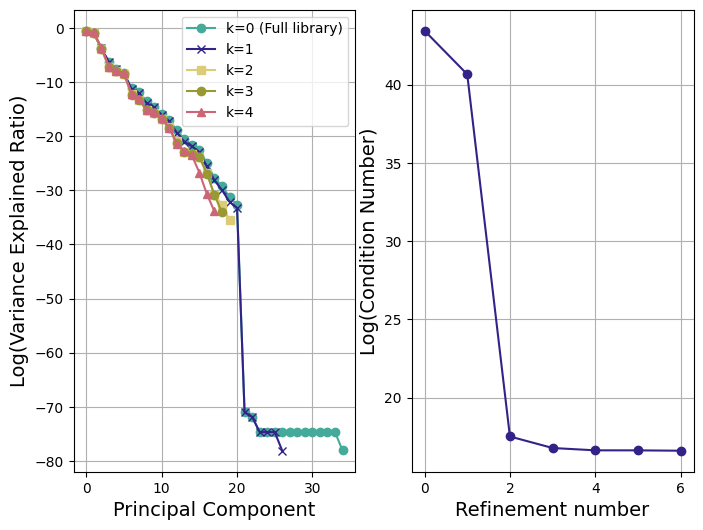

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

# Plot the log of the explained variance ratio for all libraries in the first subplot
ax1.plot(np.log(explained_variance_ratio_full), marker='o', label='k=0 (Full library)', color="#44AA99")
ax1.plot(np.log(explained_variance_ratio_refined_1), marker='x', label='k=1', color="#332288")
ax1.plot(np.log(explained_variance_ratio_refined_2), marker='s', label='k=2', color="#DDCC77")
ax1.plot(np.log(explained_variance_ratio_refined_3), marker='o', label='k=3', color="#999933")
ax1.plot(np.log(explained_variance_ratio_refined_4), marker='^', label='k=4', color="#CC6677")

ax1.set_xlabel('Principal Component', fontsize=14)
ax1.set_ylabel('Log(Variance Explained Ratio)', fontsize=14)
# ax1.set_title('Log(Variance Explained Ratio) vs Singular Value Number')
ax1.legend(fontsize=10)

ax1.grid(True)

# Plot the log of condition numbers in the second subplot
ax2.plot(np.log(cond_numbers), marker='o', color="#332288")
ax2.set_ylabel('Log(Condition Number)', fontsize=14)
ax2.set_xlabel('Refinement number', fontsize=14)
# ax2.set_title('Log of Condition Numbers for Candidate and Refined Libraries')
ax2.grid(True)

### Discovery of Dynamic Relationships + Parameter Estimation

In [842]:
# 1) dB/dt
features_to_remove, refined_candid_lib = get_refined_lib({E1, E2, AE1*AE2}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)

refined_candid_lib['d(B) /dt'] = data_matrix_df_smooth_appended['d(B) /dt']
algebraic_model_th.fit(X=refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models()['d(B) /dt']

best_rhs = best_model.to_frame().index[best_model.to_frame().iloc[:, 0] != 0][:-1].to_list()
best_relationship = best_rhs
print(best_relationship)

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
['AE1', 'd(B) /dt']


In [843]:
lin_model = LinearRegression()

best_relation_lhs = 'd(B) /dt'
best_relation_rhs = [i for i in best_relationship if i != 'd(B) /dt']

lin_model.fit(refined_candid_lib[best_relation_rhs], refined_candid_lib[best_relation_lhs])

d_B = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
d_B = {k: v for k, v in d_B.items() if abs(v) >= 0.1} # filter out small pars

d_B['LHS'] = best_relation_lhs
d_B['intercept'] = lin_model.intercept_ if abs(lin_model.intercept_) >= 0.1 else 0.

In [844]:
d_B

{'AE1': np.float64(4.991779965308536), 'LHS': 'd(B) /dt', 'intercept': 0.0}

In [845]:
# 2) dC/dt
features_to_remove, refined_candid_lib = get_refined_lib({E1, E2, AE2*AE1, A*B*C}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)

refined_candid_lib['d(C) /dt'] = data_matrix_df_smooth_appended['d(C) /dt']
algebraic_model_th.fit(X=refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models()['d(C) /dt']

best_rhs = best_model.to_frame().index[best_model.to_frame().iloc[:, 0] != 0][:-1].to_list()
best_relationship = best_rhs
print(best_relationship)

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
['AE2', 'd(C) /dt']


In [846]:
lin_model = LinearRegression()

best_relation_lhs = 'd(C) /dt'
best_relation_rhs = [i for i in best_relationship if i != 'd(C) /dt']

lin_model.fit(refined_candid_lib[best_relation_rhs], refined_candid_lib[best_relation_lhs])

d_C = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
d_C = {k: v for k, v in d_C.items() if abs(v) >= 0.1} # filter out small pars

d_C['LHS'] = best_relation_lhs
d_C['intercept'] = lin_model.intercept_ if abs(lin_model.intercept_) >= 0.1 else 0.

In [847]:
d_C

{'AE2': np.float64(2.998223460351937), 'LHS': 'd(C) /dt', 'intercept': 0.0}

In [850]:
# 3) dA/dt
features_to_remove, refined_candid_lib = get_refined_lib({E1, E2, AE2*AE1, A*B*C}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)

refined_candid_lib['d(A) /dt'] = data_matrix_df_smooth_appended['d(A) /dt']
algebraic_model_th.fit(X=refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models()['d(A) /dt']

best_rhs = best_model.to_frame().index[best_model.to_frame().iloc[:, 0] != 0][:-1].to_list()
best_relationship = best_rhs
print(best_relationship)


Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
['AE1', 'AE2', 'd(A) /dt']


In [851]:
lin_model = LinearRegression()

best_relation_lhs = 'd(A) /dt'
best_relation_rhs = [i for i in best_relationship if i != 'd(A) /dt']

lin_model.fit(refined_candid_lib[best_relation_rhs], refined_candid_lib[best_relation_lhs])

d_A = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
d_A = {k: v for k, v in d_A.items() if abs(v) >= 0.1} # filter out small pars

d_A['LHS'] = best_relation_lhs
d_A['intercept'] = lin_model.intercept_ if abs(lin_model.intercept_) >= 0.1 else 0.

In [852]:
d_A

{'AE1': np.float64(-5.133562799420246),
 'AE2': np.float64(-2.934824114394272),
 'LHS': 'd(A) /dt',
 'intercept': 0.0}

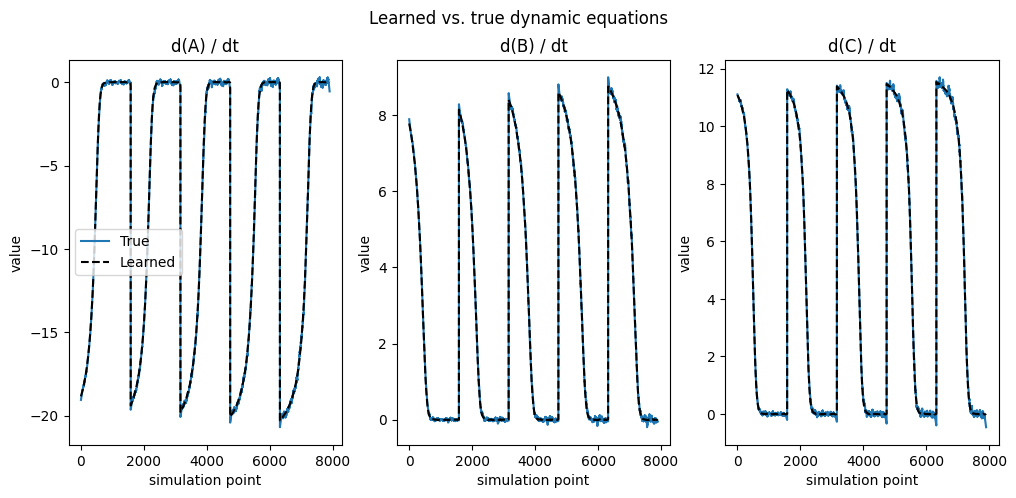

In [857]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=False)
AE1_ = data_matrix_df_smooth_appended['AE1']
AE2_ = data_matrix_df_smooth_appended['AE2']
dC_ = data_matrix_df_smooth_appended['d(C) /dt']
dB_ = data_matrix_df_smooth_appended['d(B) /dt']
dA_ = data_matrix_df_smooth_appended['d(A) /dt']

axes[0].plot(dA_, label='True')
if 'AE2' in d_A['LHS'] :
    axes[0].plot((1/d_A['d(A) /dt'])*AE2_, '--', color='black', label='Learned')
else:
    axes[0].plot(d_A['AE2']*AE2_ + d_A['AE1']*AE1_, '--', color='black', label='Learned')
axes[0].set_title("d(A) / dt")
axes[0].legend()

axes[2].plot(dC_, label='True')
if d_C['LHS'] == 'AE2':
    axes[2].plot((1/d_C['d(C) /dt'])*AE2_, '--', color='black', label='Learned')
else:
    axes[2].plot(d_C['AE2']*AE2_, '--', color='black', label='Learned')
axes[2].set_title("d(C) / dt")



axes[1].plot(dB_, label='True')
if d_B['LHS'] == 'AE1':
    axes[1].plot((1/d_B['d(B) /dt'])*AE1_, '--', color='black', label='Learned')
else:
    axes[1].plot(d_B['AE1']*AE1_, '--', color='black', label='Learned')
axes[1].set_title("d(B) / dt")

axes[0].set_xlabel("simulation point")
axes[1].set_xlabel("simulation point")
axes[2].set_xlabel("simulation point")

axes[0].set_ylabel("value")
axes[1].set_ylabel("value")
axes[2].set_ylabel("value")

# Shared title
fig.suptitle("Learned vs. true dynamic equations")

# Show the plot
plt.show()